In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl

In [2]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np

# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

2024-06-12 11:27:26.782123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:27:26.782346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:27:26.965272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/leapgestrecog/leapGestRecog"

In [4]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[4, 5, 7, ..., 4, 3, 4],
        [6, 6, 6, ..., 4, 4, 3],
        [5, 6, 6, ..., 5, 4, 4],
        ...,
        [6, 6, 6, ..., 5, 6, 4],
        [6, 5, 5, ..., 5, 6, 4],
        [4, 6, 6, ..., 5, 4, 5]], dtype=uint8),
 0]

In [8]:
# shuffle the input data
import random
random.shuffle(image_data)

In [9]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

In [10]:
label[:10]

[0, 2, 7, 8, 9, 5, 8, 5, 5, 3]

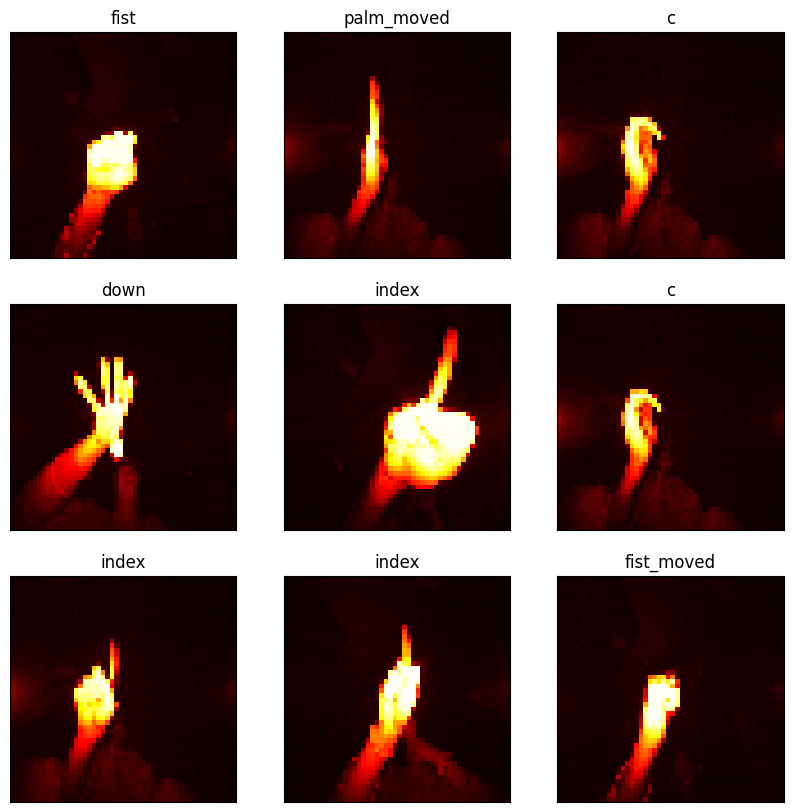

In [11]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [12]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [20]:
# Perform one-hot encoding
label_one_hot = keras.utils.to_categorical(label, num_classes=10)

# Convert the resulting array to the desired data type (dtype)
label_one_hot = label_one_hot.astype('int8')  # For example, convert to int8

# Access the first entry in the one-hot encoded array
print(label_one_hot[0])

[1 0 0 0 0 0 0 0 0 0]


In [22]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [23]:
# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)

**The Model**

In [26]:
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))


model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [27]:
model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - accuracy: 0.7193 - loss: 0.8368 - val_accuracy: 0.9950 - val_loss: 0.0192
Epoch 2/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.9929 - loss: 0.0214 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 3/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 131ms/step - accuracy: 0.9964 - loss: 0.0133 - val_accuracy: 0.9995 - val_loss: 0.0017
Epoch 4/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9986 - loss: 0.0078 - val_accuracy: 0.9992 - val_loss: 0.0056
Epoch 5/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 89s 144ms/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 6/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 146ms/step - accuracy: 0.9986 - loss: 0.0040 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 7/7
438/438 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9998 - val_loss: 0.0014


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,338,582 (12.74 MB)

 Trainable params: 1,669,290 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,669,292 (6.37 MB)

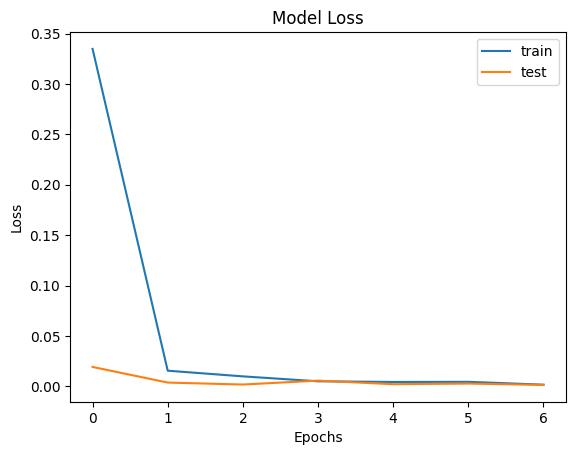

In [29]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

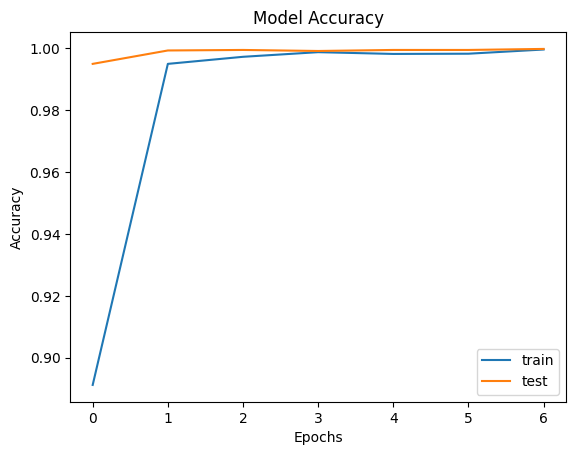

In [30]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [31]:
#calculate loss and accuracy on test data

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9999 - loss: 6.5488e-04
Test accuracy: 99.98%


**CONFUSION MATRIX**

[]

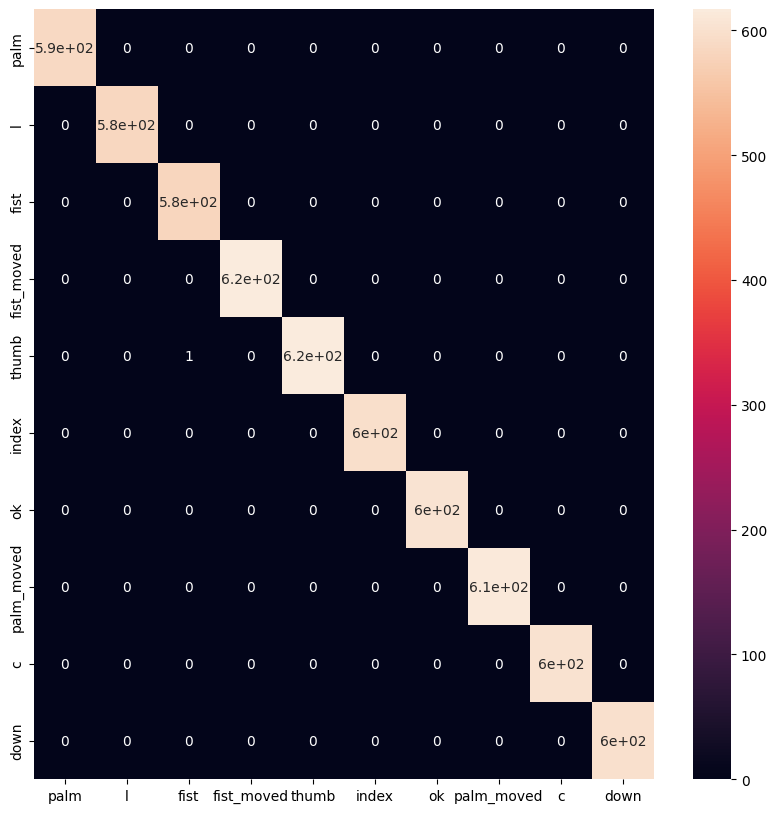

In [36]:
from keras.utils import to_categorical

# One-hot encode y_test
y_test_one_hot = to_categorical(y_test, num_classes=10)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, xticklabels=cat, yticklabels=cat)
plt.plot()
